<a href="https://colab.research.google.com/github/yu-hidaka/AD-DIFFI/blob/main/simulation_ch5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AD-DIFFI RSO SIMULATION - CHAPTER 5
Settings: N=100, Trees=100, Contam=0.05
------------------------------------------------------------

ESTABLISHING NOISE BASELINE (RSO-DIFFI) - 100 iterations
Continuous FI Baseline:  μ=1.052828, σ=0.011266
Binary FI Baseline:      μ=1.086184, σ=0.019567

RUNNING SIMULATION: 100 iterations (Orig DIFFI + AD-DIFFI RSO)
------------------------------------------------------------

High-resolution figure saved: ch5_simulation_results.png


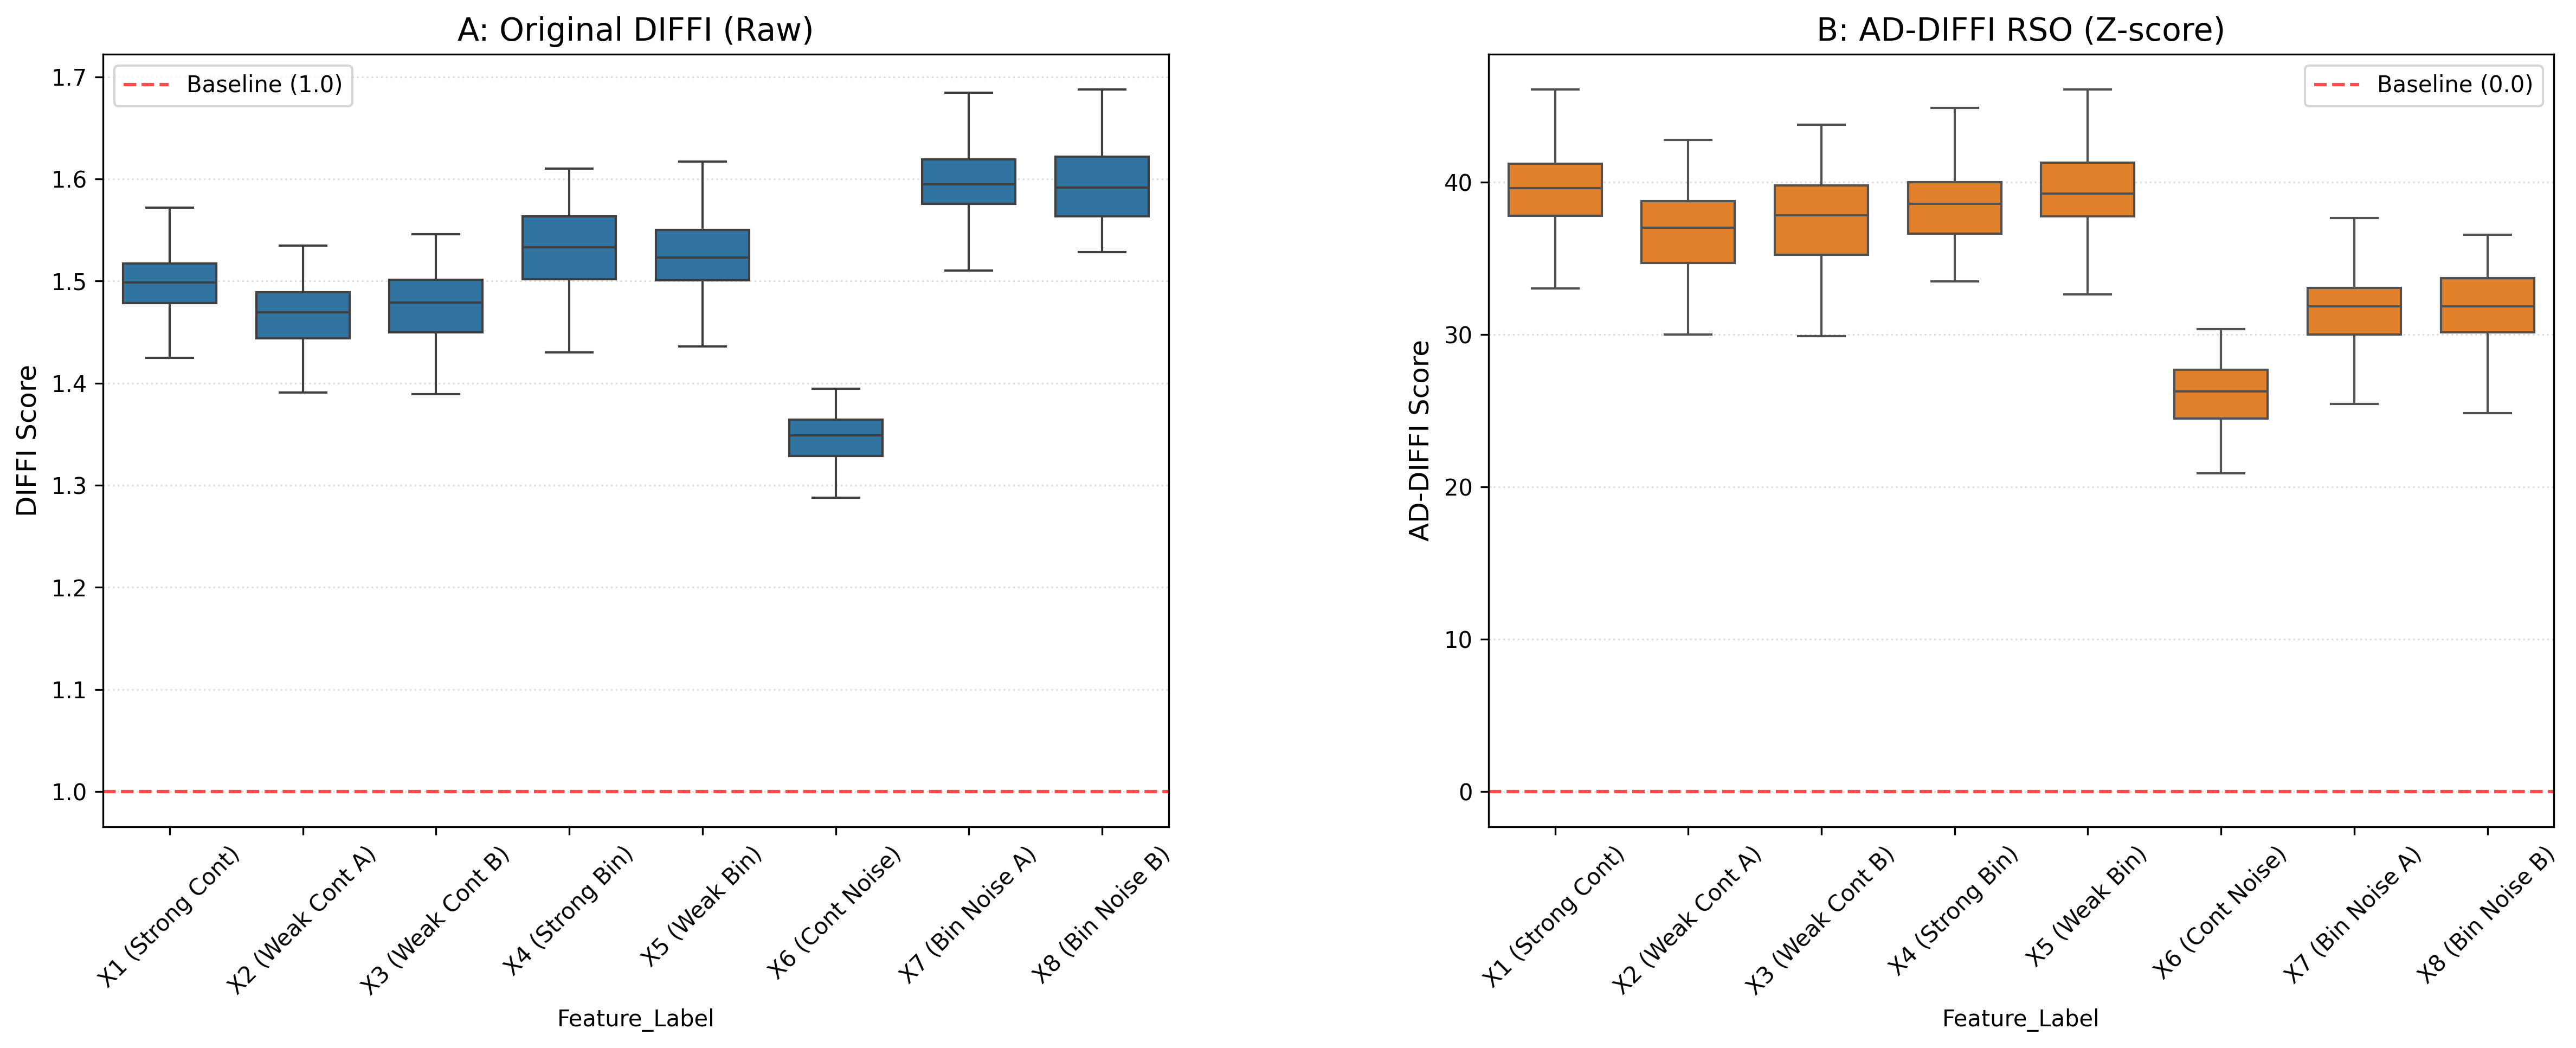


CHAPTER 5 SIMULATION SUMMARY: Original DIFFI vs AD-DIFFI RSO
| Feature_Label    |   ('mean', 'Orig_Raw') |   ('mean', 'RSO_Z') |   ('std', 'Orig_Raw') |   ('std', 'RSO_Z') |
|:-----------------|-----------------------:|--------------------:|----------------------:|-------------------:|
| X1 (Strong Cont) |                 1.498  |             39.5174 |                0.0314 |             2.7897 |
| X2 (Weak Cont A) |                 1.4661 |             36.6867 |                0.03   |             2.6641 |
| X3 (Weak Cont B) |                 1.4743 |             37.4084 |                0.0378 |             3.3551 |
| X4 (Strong Bin)  |                 1.5328 |             38.4896 |                0.0396 |             2.5093 |
| X5 (Weak Bin)    |                 1.5259 |             39.2995 |                0.0382 |             2.9305 |
| X6 (Cont Noise)  |                 1.3476 |             26.167  |                0.0271 |             2.4052 |
| X7 (Bin Noise A) |              

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Dict, List, Any
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# 1. GLOBAL SETTINGS
# =============================================================================
MIN_DEPTH = 1        # Minimum leaf depth for denominator protection
N_ITER = 100         # Signal dataset iterations
N_ITER_NOISE = 100   # Noise baseline iterations
N_TREES = 100        # Number of trees
MAX_SAMPLES = 256    # Bootstrap sample size
CONTAMINATION = 0.05 # Expected anomaly proportion
RANDOM_SEED_BASE = 42

# =============================================================================
# 2. FEATURE DEFINITIONS (8 Features: 3 Cont Signal + 2 Bin Signal + 3 Noise)
# =============================================================================
FEATURE_DEFINITIONS = [
    {'name': 'X1_Strong_Cont', 'type': 'cont', 'is_signal': True,  'strength': 'strong'},
    {'name': 'X2_Weak_Cont_A', 'type': 'cont', 'is_signal': True,  'strength': 'weak'},
    {'name': 'X3_Weak_Cont_B', 'type': 'cont', 'is_signal': True,  'strength': 'weak'},
    {'name': 'X4_Strong_Bin',  'type': 'bin',  'is_signal': True,  'strength': 'strong'},
    {'name': 'X5_Weak_Bin',    'type': 'bin',  'is_signal': True,  'strength': 'weak'},
    {'name': 'X6_Cont_Noise',  'type': 'cont', 'is_signal': False, 'strength': 'noise'},
    {'name': 'X7_Bin_Noise_A', 'type': 'bin',  'is_signal': False, 'strength': 'noise'},
    {'name': 'X8_Bin_Noise_B', 'type': 'bin',  'is_signal': False, 'strength': 'noise'},
]

# Pre-computed indices and mappings
FEATURE_TYPES = {i: f['type'] for i, f in enumerate(FEATURE_DEFINITIONS)}
FEATURE_NAMES = [f['name'] for f in FEATURE_DEFINITIONS]
CONT_INDICES = [i for i, f in enumerate(FEATURE_DEFINITIONS) if f['type'] == 'cont']
BIN_INDICES = [i for i, f in enumerate(FEATURE_DEFINITIONS) if f['type'] == 'bin']

# =============================================================================
# 3. DATA GENERATION FUNCTIONS
# =============================================================================
def generate_mixed_signal_dataset(n_total: int = 1000, contamination: float = 0.05,
                                seed: int = 42) -> pd.DataFrame:
    """Generate mixed signal + noise dataset with controlled anomaly injection."""
    n_normal = int(n_total * (1 - contamination))
    n_anomaly = n_total - n_normal
    rng = np.random.default_rng(seed)
    signal_features = [f for f in FEATURE_DEFINITIONS if f['is_signal']]
    n_signals = len(signal_features)
    n_a_per_signal = n_anomaly // n_signals if n_signals > 0 else 0

    X_dict = {}
    for i, feat in enumerate(FEATURE_DEFINITIONS):
        name, ftype, is_sig, strength = feat['name'], feat['type'], feat['is_signal'], feat['strength']

        if is_sig:
            n_a_current = n_a_per_signal + (1 if i < (n_anomaly % n_signals) else 0)
            if ftype == 'cont':
                loc_sig = 50 if strength == 'strong' else 15
                scale_sig = 0.5 if strength == 'strong' else 1
                X_normal = rng.normal(loc=10, scale=1, size=n_normal)
                X_sig = rng.normal(loc=loc_sig, scale=scale_sig, size=n_a_current)
                X_all = np.concatenate([X_normal, X_sig])
            else:  # binary
                p_sig_one = 0.9 if strength == 'strong' else 0.5
                X_normal = np.zeros(n_normal)
                X_sig_ones = np.ones(int(n_a_current * p_sig_one))
                X_sig_zeros = np.zeros(n_a_current - len(X_sig_ones))
                X_all = np.concatenate([X_normal, X_sig_ones, X_sig_zeros])

            # Fill remaining samples
            if len(X_all) < n_total:
                X_filler = (rng.choice([0, 1], size=n_total-len(X_all), p=[0.5, 0.5])
                           if ftype == 'bin' else rng.uniform(0, 20, size=n_total-len(X_all)))
                X_all = np.concatenate([X_all, X_filler])
            X_dict[name] = X_all[:n_total]
        else:
            # Pure noise features
            X_dict[name] = (rng.uniform(low=0, high=20, size=n_total) if ftype == 'cont'
                           else rng.choice([0, 1], size=n_total, p=[0.5, 0.5]))

    X = pd.DataFrame(X_dict)
    return X.sample(frac=1, random_state=seed).reset_index(drop=True)

def generate_noise_only_dataset(n_total: int = 1000, seed: int = 42) -> pd.DataFrame:
    """Generate pure noise dataset (no signal injection)."""
    rng = np.random.default_rng(seed)
    X_dict = {}
    for feat in FEATURE_DEFINITIONS:
        ftype = feat['type']
        X_dict[feat['name']] = (rng.uniform(0, 20, size=n_total) if ftype == 'cont'
                               else rng.choice([0, 1], size=n_total, p=[0.5, 0.5]))
    return pd.DataFrame(X_dict)

# =============================================================================
# 4. FEATURE IMPORTANCE CALCULATION (RSO-CONSTRAINED DIFFI)
# =============================================================================
def diffi_ib_binary_rso(iforest: IsolationForest, X_data: np.ndarray,
                       feature_types: Dict[int, str]) -> np.ndarray:
    """Calculate DIFFI scores with Root-Split-Only (RSO) constraint for binary features."""
    num_feat = X_data.shape[1]
    estimators = iforest.estimators_
    cfi_outliers_ib = np.zeros(num_feat, dtype=float)
    cfi_inliers_ib = np.zeros(num_feat, dtype=float)
    counter_outliers_ib = np.zeros(num_feat, dtype=int)
    counter_inliers_ib = np.zeros(num_feat, dtype=int)
    in_bag_samples = iforest.estimators_samples_

    # Global anomaly threshold
    global_scores = iforest.decision_function(X_data)
    global_threshold = np.percentile(global_scores, 100 * iforest.contamination)

    for k, estimator in enumerate(estimators):
        in_bag_sample = list(in_bag_samples[k])
        X_ib = X_data[in_bag_sample, :]
        scores_ib = global_scores[in_bag_sample]

        X_outliers_ib = X_ib[scores_ib < global_threshold]
        X_inliers_ib = X_ib[scores_ib >= global_threshold]
        if X_inliers_ib.shape[0] == 0 or X_outliers_ib.shape[0] == 0:
            continue

        # Tree structure extraction
        tree = estimator.tree_
        n_nodes = tree.node_count
        children_left = tree.children_left
        children_right = tree.children_right
        feature = tree.feature
        n_samples_node = tree.n_node_samples

        # Compute node depths
        node_depth = np.zeros(n_nodes, dtype=np.int64)
        stack = [(0, -1)]
        while stack:
            node_id, parent_depth = stack.pop()
            node_depth[node_id] = parent_depth + 1
            if children_left[node_id] != children_right[node_id]:
                stack.append((children_left[node_id], parent_depth + 1))
                stack.append((children_right[node_id], parent_depth + 1))

        # Imbalance adjustment factors
        current_lambda_adj = np.zeros(n_nodes, dtype=float)
        for node in range(n_nodes):
            if children_left[node] != children_right[node]:
                n_parent = n_samples_node[node]
                n_left = n_samples_node[children_left[node]]
                n_right = n_samples_node[children_right[node]]
                ratio_small = min(n_left, n_right) / n_parent
                current_lambda_adj[node] = 1.0 - ratio_small

        def calculate_contribution(X_path, cfi, counter):
            node_indicator = estimator.decision_path(X_path).toarray()
            for i in range(len(X_path)):
                path = np.where(node_indicator[i] == 1)[0]
                if len(path) == 0:
                    continue

                # Depth-based scaling
                depth_leaf = node_depth[path[-1]]
                h_leaf = max(depth_leaf, MIN_DEPTH)
                depth_scaling = 1.0 / h_leaf

                for node in path:
                    feat_idx = feature[node]
                    if feat_idx >= 0:
                        feat_type = feature_types[feat_idx]

                        # RSO CONSTRAINT: Skip binary splits except root (depth=0)
                        if feat_type == 'bin' and node_depth[node] > 0:
                            continue

                        lambda_val = current_lambda_adj[node]
                        contribution = depth_scaling * lambda_val
                        cfi[feat_idx] += contribution
                        counter[feat_idx] += 1

        calculate_contribution(X_outliers_ib, cfi_outliers_ib, counter_outliers_ib)
        calculate_contribution(X_inliers_ib, cfi_inliers_ib, counter_inliers_ib)

    # Normalize and compute DIFFI ratio
    fi_outliers = np.divide(cfi_outliers_ib, counter_outliers_ib,
                           out=np.zeros_like(cfi_outliers_ib), where=counter_outliers_ib > 0)
    fi_inliers = np.divide(cfi_inliers_ib, counter_inliers_ib,
                          out=np.zeros_like(cfi_inliers_ib), where=counter_inliers_ib > 0)
    fi_rso = np.divide(fi_outliers, fi_inliers,
                      out=np.zeros_like(fi_outliers), where=fi_inliers != 0)
    return fi_rso

def diffi_ib_original(iforest: IsolationForest, X_data: np.ndarray,
                     feature_types: Dict[int, str]) -> np.ndarray:
    """Original DIFFI (no RSO constraint)."""
    num_feat = X_data.shape[1]
    estimators = iforest.estimators_
    cfi_outliers = np.zeros(num_feat, dtype=float)
    cfi_inliers = np.zeros(num_feat, dtype=float)
    counter_outliers = np.zeros(num_feat, dtype=int)
    counter_inliers = np.zeros(num_feat, dtype=int)
    in_bag_samples = iforest.estimators_samples_

    global_scores = iforest.decision_function(X_data)
    global_threshold = np.percentile(global_scores, 100 * iforest.contamination)

    for k, estimator in enumerate(estimators):
        in_bag_sample = list(in_bag_samples[k])
        X_ib = X_data[in_bag_sample, :]
        scores_ib = global_scores[in_bag_sample]

        X_outliers_ib = X_ib[scores_ib < global_threshold]
        X_inliers_ib = X_ib[scores_ib >= global_threshold]
        if len(X_inliers_ib) == 0 or len(X_outliers_ib) == 0:
            continue

        tree = estimator.tree_
        n_nodes = tree.node_count
        children_left = tree.children_left
        children_right = tree.children_right
        feature = tree.feature
        n_samples_node = tree.n_node_samples

        node_depth = np.zeros(n_nodes, dtype=np.int64)
        stack = [(0, -1)]
        while stack:
            node_id, parent_depth = stack.pop()
            node_depth[node_id] = parent_depth + 1
            if children_left[node_id] != children_right[node_id]:
                stack.append((children_left[node_id], parent_depth + 1))
                stack.append((children_right[node_id], parent_depth + 1))

        current_lambda_adj = np.zeros(n_nodes, dtype=float)
        for node in range(n_nodes):
            if children_left[node] != children_right[node]:
                n_parent = n_samples_node[node]
                n_left = n_samples_node[children_left[node]]
                n_right = n_samples_node[children_right[node]]
                ratio_small = min(n_left, n_right) / n_parent
                current_lambda_adj[node] = 1.0 - ratio_small

        def calculate_contribution(X_path, cfi, counter):
            node_indicator = estimator.decision_path(X_path).toarray()
            for i in range(len(X_path)):
                path = np.where(node_indicator[i] == 1)[0]
                if len(path) == 0:
                    continue

                depth_leaf = node_depth[path[-1]]
                h_leaf = max(depth_leaf, MIN_DEPTH)
                depth_scaling = 1.0 / h_leaf

                for node in path:
                    feat_idx = feature[node]
                    if feat_idx >= 0:
                        lambda_val = current_lambda_adj[node]
                        contribution = depth_scaling * lambda_val
                        cfi[feat_idx] += contribution
                        counter[feat_idx] += 1

        calculate_contribution(X_outliers_ib, cfi_outliers, counter_outliers)
        calculate_contribution(X_inliers_ib, cfi_inliers, counter_inliers)

    fi_outliers = np.divide(cfi_outliers, counter_outliers,
                           out=np.zeros_like(cfi_outliers), where=counter_outliers > 0)
    fi_inliers = np.divide(cfi_inliers, counter_inliers,
                          out=np.zeros_like(cfi_inliers), where=counter_inliers > 0)
    fi_orig = np.divide(fi_outliers, fi_inliers,
                       out=np.zeros_like(fi_outliers), where=fi_inliers != 0)
    return fi_orig

# =============================================================================
# 5. NOISE BASELINE ESTABLISHMENT
# =============================================================================
def establish_noise_baseline(n_iter_noise: int, feature_types: Dict[int, str]) -> Tuple[float, float, float, float]:
    """Establish noise baseline (mean/SD) for continuous and binary features."""
    print(f"\n{'='*70}")
    print(f"ESTABLISHING NOISE BASELINE (RSO-DIFFI) - {n_iter_noise} iterations")
    print(f"{'='*70}")

    raw_scores_list = []
    for k in range(n_iter_noise):
        X_data = generate_noise_only_dataset(seed=RANDOM_SEED_BASE + k).values
        iforest = IsolationForest(n_estimators=N_TREES, max_samples=MAX_SAMPLES,
                                contamination=CONTAMINATION, random_state=k, bootstrap=False)
        iforest.fit(X_data)
        fi_rso = diffi_ib_binary_rso(iforest, X_data, feature_types)
        raw_scores_list.append(fi_rso)

    fi_matrix = np.vstack(raw_scores_list)

    # Type-specific baselines
    cont_scores = fi_matrix[:, CONT_INDICES]
    bin_scores = fi_matrix[:, BIN_INDICES]

    mean_cont, sd_cont = cont_scores.mean(), cont_scores.std()
    mean_bin, sd_bin = bin_scores.mean(), bin_scores.std()

    print(f"Continuous FI Baseline:  μ={mean_cont:.6f}, σ={sd_cont:.6f}")
    print(f"Binary FI Baseline:      μ={mean_bin:.6f}, σ={sd_bin:.6f}")
    print(f"{'='*70}\n")

    return mean_cont, sd_cont, mean_bin, sd_bin

# =============================================================================
# 6. SIMULATION & STANDARDIZATION
# =============================================================================
def collect_orig_raw_and_rso_z(n_iter: int, feature_types: Dict[int, str],
                             cont_mean: float, cont_sd: float,
                             bin_mean: float, bin_sd: float) -> pd.DataFrame:
    """Run simulation collecting Original DIFFI (Raw) and AD-DIFFI RSO (Z-score)."""
    print(f"RUNNING SIMULATION: {n_iter} iterations (Orig DIFFI + AD-DIFFI RSO)")
    print("-" * 60)

    orig_raw_scores = []
    rso_z_scores = []

    for k in range(n_iter):
        X_data = generate_mixed_signal_dataset(seed=RANDOM_SEED_BASE + k).values
        iforest = IsolationForest(n_estimators=N_TREES, max_samples=MAX_SAMPLES,
                                contamination=CONTAMINATION, random_state=k, bootstrap=False)
        iforest.fit(X_data)

        # Original DIFFI (Raw scores)
        fi_orig = diffi_ib_original(iforest, X_data, feature_types)
        orig_raw_scores.append(fi_orig)

        # RSO-DIFFI (Raw -> Z-standardized to AD-DIFFI)
        fi_rso_raw = diffi_ib_binary_rso(iforest, X_data, feature_types)
        fi_rso_z = np.zeros_like(fi_rso_raw)

        for i, feat_name in enumerate(FEATURE_NAMES):
            feat_type = feature_types[i]
            raw_score = fi_rso_raw[i]
            if feat_type == 'cont':
                fi_rso_z[i] = (raw_score - cont_mean) / cont_sd if cont_sd > 0 else 0.0
            else:  # binary
                fi_rso_z[i] = (raw_score - bin_mean) / bin_sd if bin_sd > 0 else 0.0

        rso_z_scores.append(fi_rso_z)

    # Combine results
    df_orig = pd.DataFrame(np.vstack(orig_raw_scores), columns=FEATURE_NAMES)
    df_orig['Scenario'] = 'Orig_Raw'

    df_rso_z = pd.DataFrame(np.vstack(rso_z_scores), columns=FEATURE_NAMES)
    df_rso_z['Scenario'] = 'RSO_Z'

    return pd.concat([df_orig, df_rso_z], ignore_index=True)

# =============================================================================
# 7. VISUALIZATION & SUMMARY
# =============================================================================
def plot_orig_vs_rso_comparison(results_df: pd.DataFrame, feature_defs: List[Dict]):
    """Create side-by-side boxplots: Original DIFFI vs AD-DIFFI RSO."""
    feature_labels = {
        'X1_Strong_Cont': 'X1 (Strong Cont)',
        'X2_Weak_Cont_A': 'X2 (Weak Cont A)',
        'X3_Weak_Cont_B': 'X3 (Weak Cont B)',
        'X4_Strong_Bin': 'X4 (Strong Bin)',
        'X5_Weak_Bin': 'X5 (Weak Bin)',
        'X6_Cont_Noise': 'X6 (Cont Noise)',
        'X7_Bin_Noise_A': 'X7 (Bin Noise A)',
        'X8_Bin_Noise_B': 'X8 (Bin Noise B)',
    }

    all_features = [f['name'] for f in feature_defs]
    df_plot = results_df[['Scenario'] + all_features].melt(
        id_vars='Scenario', var_name='Feature', value_name='Score'
    )
    df_plot['Feature_Label'] = df_plot['Feature'].map(feature_labels)
    feature_order = [feature_labels[f['name']] for f in feature_defs]

    # Create side-by-side subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), dpi=300)

    # Left: Original DIFFI (Raw)
    sns.boxplot(data=df_plot[df_plot['Scenario'] == 'Orig_Raw'],
                x='Feature_Label', y='Score', order=feature_order,
                color='#1f77b4', ax=ax1, width=0.7, showfliers=False)
    ax1.set_title('A: Original DIFFI (Raw)', fontsize=14, fontweight='normal')
    ax1.set_ylabel('DIFFI Score', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', linestyle=':', alpha=0.4)
    ax1.axhline(y=1.0, color='r', linestyle='--', alpha=0.7, label='Baseline (1.0)')
    ax1.legend()

    # Right: AD-DIFFI RSO (Z-score)
    sns.boxplot(data=df_plot[df_plot['Scenario'] == 'RSO_Z'],
                x='Feature_Label', y='Score', order=feature_order,
                color='#ff7f0e', ax=ax2, width=0.7, showfliers=False)
    ax2.set_title('B: AD-DIFFI RSO (Z-score)', fontsize=14, fontweight='normal')
    ax2.set_ylabel('AD-DIFFI Score', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(axis='y', linestyle=':', alpha=0.4)
    ax2.axhline(y=0.0, color='r', linestyle='--', alpha=0.7, label='Baseline (0.0)')
    ax2.legend()

    plt.tight_layout()
    plt.subplots_adjust(top=0.88, wspace=0.3)

    # Save high-res figure
    plt.savefig('ch5_simulation_results.png', bbox_inches='tight', dpi=300,
                facecolor='white', edgecolor='none')
    print("\nHigh-resolution figure saved: ch5_simulation_results.png")

    plt.show()

    # Summary statistics table
    summary = df_plot.groupby(['Scenario', 'Feature_Label'])['Score'].agg(['mean', 'std']).round(4)
    summary = summary.pivot_table(index='Feature_Label', columns='Scenario',
                                 values=['mean', 'std']).reindex(feature_order)

    print("\n" + "="*80)
    print("CHAPTER 5 SIMULATION SUMMARY: Original DIFFI vs AD-DIFFI RSO")
    print("="*80)
    print(summary.to_markdown())
    print("="*80)

# =============================================================================
# 8. MAIN EXECUTION
# =============================================================================
def main():
    """Execute Chapter 5 simulation workflow."""
    print("AD-DIFFI RSO SIMULATION - CHAPTER 5")
    print(f"Settings: N={N_ITER}, Trees={N_TREES}, Contam={CONTAMINATION}")
    print("-" * 60)

    # Step 1: Establish noise baseline
    cont_mean, cont_sd, bin_mean, bin_sd = establish_noise_baseline(
        N_ITER_NOISE, FEATURE_TYPES
    )

    # Step 2: Run main simulation
    results_df = collect_orig_raw_and_rso_z(
        N_ITER, FEATURE_TYPES, cont_mean, cont_sd, bin_mean, bin_sd
    )

    # Step 3: Visualize and summarize
    plot_orig_vs_rso_comparison(results_df, FEATURE_DEFINITIONS)

    print("\nChapter 5 simulation completed successfully!")
    print(f"Results saved in: ch5_simulation_results.png")

if __name__ == '__main__':
    main()
